## Code walkthrough for LANCE: Stress-testing Visual Models by Generating Language-guided Counterfactual Images (NeurIPS 2023)

In [53]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd

import torch
from torchvision.models import resnet50, ResNet50_Weights

import lance
from lance.utils.misc_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Language-guided Counterfactual Images

In [54]:
# Point to ImageNet validation folder
img_dir = 'data/iminigenet'
out_dir = 'outputs/walkthrough2'
device = torch.device('cuda:0')

#### Augment with generated counterfactuals <br/> [Note: Can uncomment run cell below to generate counterfactuals, but ideally follow README instructions and use accelerate to parallelize + significantly speed up generation]

In [55]:
# Run LANCE
# lance.generate(img_dir, out_dir, device=device)

## Analyze sensitivity

In [56]:
# Construct IN1K mapping
in1k_classlist = 'datasets/in1k_classlist.txt'

with open(in1k_classlist, 'r') as f:
    in1k_classes = [ln.replace(',', '').replace('"', '').strip().lower() for ln in f.readlines()]
in1k_class_to_idx = {c: i for i, c in enumerate(in1k_classes)}

# Load model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device).eval()

### Generate augmented dataloader and append predictions

In [186]:
%autoreload 2
out_dir = 'outputs/HardImageNet'
df = lance.inspect(model, out_dir, in1k_class_to_idx, device)

In [187]:
display(HTML(render_as_html(df.head(n=10), sort_by=["Label", "Image", "Edit Type", "Sensitivity"])))

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
8,,balance beam,,a photo of a young woman balancing on one leg above a balance beam in a gymnastics gym with her arms outstretched,a photo of a young woman balancing on one leg above a balance beam in a gymnastics gym with her arms outstretched on a snowy day,weather,,,0.21
7,,balance beam,,a photo of a young woman balancing on one leg above a balance beam in a gymnastics gym with her arms outstretched,a photo of a young woman balancing on one leg above a balance beam in a gymnastics gym with her arms outstretched on a rainy day,weather,,,0.00
9,,balance beam,,a photo of a young woman balancing on one leg above a balance beam in a gymnastics gym with her arms outstretched,a photo of a young woman balancing on one leg above a balance beam in a gymnastics gym with her arms outstretched and a mat trampoline in the foreground,background,,,0.02
6,,balance beam,,a photo of a woman doing a trick on a beam with a ball in her hand and a black background,a photo of a woman doing a trick on a beam with a ball in her hand and a tattoo on her arm and a black background,adjective,,,6.04
2,,balance beam,,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background during a thunderstorm,weather,,,41.78
1,,balance beam,,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background in the snow,weather,,,37.02
0,,balance beam,,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background in the rain,weather,,,32.83
5,,balance beam,,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background on a snowy winter day,weather,,,13.82
4,,balance beam,,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background during a hailstorm,weather,,,13.25
3,,balance beam,,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background,a photo of a young boy standing near a balance beam in a gym with a woman and a man in the background during a blizzard,weather,,,8.31


#### Derive class-level insights by clustering common edits

In [188]:
%autoreload 2
df_cluster = lance.cluster_class_edits(df, device)

=>Clustering edits for balance beam
=>Clustering edits for baseball player
=>Clustering edits for dog sled
=>Clustering edits for gymnastic horizontal bar
=>Clustering edits for hockey puck
=>Clustering edits for howler monkey
=>Clustering edits for keyboard space bar
=>Clustering edits for miniskirt
=>Clustering edits for patio
=>Clustering edits for seat belt
=>Clustering edits for ski
=>Clustering edits for snorkel
=>Clustering edits for sunglasses
=>Clustering edits for swimming cap
=>Clustering edits for volleyball


In [191]:
df_cluster['Image'][0]

'outputs/HardImageNet/balance beam/ILSVRC2012_val_00024511/img.jpeg'

## Visualize top-3 most sensitive clusters per class

In [195]:
%autoreload 2
from collections import defaultdict
valid_clusters = defaultdict(list)
classes = df_cluster['Label'].unique()
for cls in classes:
    header = "# Class: {}".format(cls)
    display(print_header(header))
    df_class = df_cluster[df_cluster['Label']==cls]
    # Sort clusters by mean sensitivity
    unique_clusters = df_class['Cluster'].unique()
    unique_clusters = sorted(unique_clusters, key=lambda x: df_class[df_class['Cluster']==x]['Sensitivity'].mean(), reverse=True)
    for ix in unique_clusters:
        df_class_cluster = df_class[df_class['Cluster']==ix]
        if len(df_class_cluster.index)>1:
            header = "## Cluster {}: Sensitivity={:.2f}%".format(ix, df_class_cluster['Sensitivity'].mean())
            display(print_header(header))
            html = render_as_html(df_class_cluster.head(n=5), sort_by=["Image"])
            display(HTML(html))
            # write html to file
            with open("outputs/HardImageNet/{}_cl{}_{:.2f}.html".format(cls, ix, df_class_cluster['Sensitivity'].mean()), 'w') as f:
                f.write(html)
            valid_clusters[cls].append(ix)
            if len(valid_clusters[cls])>=3: break
    print("\n\n\n")

# Class: balance beam

## Cluster 4: Sensitivity=32.87%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
77,,balance beam,,a photo of a little girl standing on a wooden balance beam in front of a wooden deck and stairs,a photo of a little girl and a little boy standing on a wooden balance beam in front of a wooden deck and stairs,subject,,,5.86
87,,balance beam,,a photo of a little girl standing on a pink balance beam in a room with a green wall,a photo of a little boy and a little girl standing on a pink balance beam in a room with a green wall,subject,,,37.10
88,,balance beam,,a photo of a little girl standing on a pink balance beam in a room with a green wall,a photo of a little girl and her best friend standing on a pink balance beam in a room with a green wall,subject,,,40.23
89,,balance beam,,a photo of a little girl standing on a pink balance beam in a room with a green wall,a photo of a little girl and her brother standing on a pink balance beam in a room with a green wall,subject,,,41.47
92,,balance beam,,a photo of a little girl standing on a pink balance beam in a room with a green wall,a photo of a little girl and her cousin standing on a pink balance beam in a room with a green wall,subject,,,39.70


## Cluster 6: Sensitivity=18.66%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
9,,balance beam,,a photo of a young woman balancing on one leg above a balance beam in a gymnastics gym with her arms outstretched,a photo of a young woman balancing on one leg above a balance beam in a gymnastics gym with her arms outstretched and a mat trampoline in the foreground,background,,,0.02
20,,balance beam,,a photo of a person doing a trick on a balance beam on a balance beam with a black background,a photo of a person doing a trick on a balance beam on a balance beam with a black and green background,weather,,,41.33
21,,balance beam,,a photo of a person doing a trick on a balance beam on a balance beam with a black background,a photo of a person doing a trick on a balance beam on a balance beam with a black and red background,weather,,,39.87
22,,balance beam,,a photo of a person doing a trick on a balance beam on a balance beam with a black background,a photo of a person doing a trick on a balance beam on a balance beam with a black and pink background,weather,,,55.32
11,,balance beam,,a photo of a woman on a balance beam with her hands raised on a balance beam at a gymnastics competition,a photo of a young woman on a balance beam with her hands raised on a balance beam at a gymnastics competition,adjective,,,2.00


## Cluster 5: Sensitivity=16.53%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
78,,balance beam,,a photo of a little girl standing on a wooden balance beam in front of a wooden deck and stairs,a photo of a little girl and her brother and her friend standing on a wooden balance beam in front of a wooden deck and stairs,subject,,,0.00
90,,balance beam,,a photo of a little girl standing on a pink balance beam in a room with a green wall,a photo of a little girl and her siblings standing on a pink balance beam in a room with a green wall,subject,,,24.57
91,,balance beam,,a photo of a little girl standing on a pink balance beam in a room with a green wall,a photo of a little girl and her classmates standing on a pink balance beam in a room with a green wall,subject,,,25.03


# Class: baseball player

## Cluster 3: Sensitivity=23.69%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
162,,baseball player,,a photo of a baseball player holding a bat on top of a baseball field next to a crowd,a photo of a baseball player holding a bat on top of a baseball field next to a crowd on a foggy day,weather,,,93.16
160,,baseball player,,a photo of a baseball player holding a bat in front of a crowd of people at a baseball game,a photo of a baseball player holding a bat in front of a crowd of people at a baseball game on a foggy day,weather,,,12.28
99,,baseball player,,a photo of a baseball player holding a bat on a field with a crowd watching from the bleachers,a photo of a baseball player holding a bat on a field with a crowd watching from the bleachers on a foggy day,weather,,,22.69
115,,baseball player,,a photo of a baseball player standing on a field with a glove in his hand and a ball in his hand,a photo of a baseball player standing on a field with a glove in his hand and a ball in his hand on a foggy day,weather,,,15.54
135,,baseball player,,a photo of a man holding a baseball bat on top of a lush green field,a photo of a man holding a baseball bat on top of a lush green field on a foggy day,weather,,,18.08


## Cluster 9: Sensitivity=13.66%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
123,,baseball player,,a photo of a baseball player holding a bat on top of a field of grass next to home plate,a photo of a baseball player holding a bat on top of a field of grass with the mountains in the background next to home plate,subject,,,37.25
108,,baseball player,,a photo of a black and white photo of a man in a baseball uniform with a hat on,a photo of a black and white photo of a man in a baseball uniform with a hat on a field with trees in the background,background,,,11.15
104,,baseball player,,a photo of a young boy holding a baseball bat on top of a baseball field next to a man,a photo of a young boy holding a baseball bat on a top of a baseball field next to a man with a dog sitting adjacent,background,,,0.37
149,,baseball player,,a photo of a baseball player standing in the dugout of a baseball field with his bat in his hand,a photo of a baseball player standing in the dugout of a baseball field with his bat in his hand and a full moon shining over the field,background,,,9.96
134,,baseball player,,a photo of a young boy in a baseball uniform holding a bat on top of a baseball field,a photo of a young boy in a baseball uniform holding a bat on top of a pristine baseball field with a clear view of the mountains,background,,,9.56


## Cluster 0: Sensitivity=12.65%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
122,,baseball player,,a photo of a baseball player holding a bat on top of a field of grass next to home plate,a photo of a young baseball player holding a bat on top of a field of grass next to home plate,adjective,,,0.53
107,,baseball player,,a photo of a black and white photo of a man in a baseball uniform with a hat on,a photo of a black and white photo of a young man in a baseball uniform with a hat on,adjective,,,16.50
100,,baseball player,,a photo of a baseball player holding a bat on a field with a crowd watching from the bleachers,a photo of a fiery baseball player holding a bat on a field with a crowd watching from the bleachers,adjective,,,38.41
101,,baseball player,,a photo of a baseball player holding a bat on a field with a crowd watching from the bleachers,a photo of a baseball player holding a bat on a lacrosse field with a crowd watching from the bleachers,background,,,3.23
96,,baseball player,,a photo of a baseball player on the cover of a magazine with a baseball bat in his hand,"a photo of a quarterback on the cover of a magazine with a throw, a baseball player on the cover of a magazine with a baseball bat in his hand",subject,,,9.20


# Class: dog sled

## Cluster 5: Sensitivity=41.55%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
212,,dog sled,,a photo of a man in an orange jacket is pulling a dog sled with two dogs on it,a photo of a man in an orange jacket is pulling a dog sled through a desert with two dogs on it,background,,,4.48
213,,dog sled,,a photo of a man in an orange jacket is pulling a dog sled with two dogs on it,a photo of a man in an orange jacket is pulling a dog sled on a beach with two dogs on it,background,,,49.82
181,,dog sled,,a photo of a group of people standing around a dog pulling a dog sled with a dog on it,a photo of a group of people standing around a dog pulling a dog sled with a dog on it in a deserted beach,background,,,70.36


## Cluster 2: Sensitivity=16.83%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
188,,dog sled,,a photo of a woman in a red jacket is pulling two dogs on a leash in the woods,a photo of a woman in a red jacket is pulling two dogs on a leash in the snowy woods,weather,,,21.48
191,,dog sled,,a photo of a woman in a red jacket is pulling two dogs on a leash in the woods,a photo of a woman in a fluffy red jacket is pulling two dogs on a leash in the woods,adjective,,,9.11
192,,dog sled,,a photo of a woman in a red jacket is pulling two dogs on a leash in the woods,a photo of a woman in a velvet red jacket is pulling two dogs on a leash in the woods,adjective,,,19.81
214,,dog sled,,a photo of a husky dog is tied to a dog sled in the snow with a leash attached to it,a photo of a white husky dog is tied to a dog sled in the snow with a leash attached to it,adjective,,,11.08
215,,dog sled,,a photo of a husky dog is tied to a dog sled in the snow with a leash attached to it,a photo of a fluffy husky dog is tied to a dog sled in the snow with a leash attached to it,adjective,,,22.66


## Cluster 4: Sensitivity=11.56%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
186,,dog sled,,a photo of a man and two dogs pulling a dog sled down a dirt road,a photo of a man and two fluffy dogs pulling a dog sled down a dirt road,adjective,,,81.74
174,,dog sled,,a photo of a man riding a dog sled pulled by two dogs on a snow covered path next to a fence,a photo of a young man riding a dog sled pulled by two dogs on a snow covered path next to a fence,adjective,,,18.74
178,,dog sled,,a photo of a group of dogs with a dog sled running in the snow pulling a dog sled with a person in it,a photo of a group of dogs with a dog sled running in the rainbow snow pulling a dog sled with a person in it,weather,,,3.22
179,,dog sled,,a photo of a group of dogs with a dog sled running in the snow pulling a dog sled with a person in it,a photo of a group of hungry dogs with a dog sled running in the snow pulling a dog sled with a person in it,adjective,,,0.58
180,,dog sled,,a photo of a group of dogs with a dog sled running in the snow pulling a dog sled with a person in it,a photo of a group of fluffy dogs with a dog sled running in the snow pulling a dog sled with a person in it,adjective,,,0.36


# Class: gymnastic horizontal bar

## Cluster 0: Sensitivity=48.13%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
381,,gymnastic horizontal bar,,a photo of a woman on a balance beam in a competition wearing a blue and red leotard suit,a photo of a woman on a balance beam in a competition wearing a blue and red leotard suit with a stormy sky in the background,weather,,,6.78
307,,gymnastic horizontal bar,,a photo of a woman is doing a handstand on a parallel bar in an indoor gym,a photo of a woman is doing a handstand on a parallel bar in an indoor gym under the moon,weather,,,82.64
308,,gymnastic horizontal bar,,a photo of a woman is doing a handstand on a parallel bar in an indoor gym,a photo of a woman is doing a handstand on a parallel bar in an indoor gym under a bluffcloud,weather,,,84.17
305,,gymnastic horizontal bar,,a photo of a woman hanging from a metal bar in a park with a tree in the background,a photo of a woman hanging from a metal bar in a park with a tree in the background and a rainbow appearing over the tree,background,,,18.92


## Cluster 5: Sensitivity=22.37%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
285,,gymnastic horizontal bar,,a photo of a woman is doing a trick on the balance bars at a gymnastics competition with a crowd watching,a photo of a woman is doing a trick on the balance bars at a gymnastics competition on a rainy day with a crowd watching,weather,,,3.95
286,,gymnastic horizontal bar,,a photo of a woman is doing a trick on the balance bars at a gymnastics competition with a crowd watching,a photo of a woman is doing a trick on the balance bars at a gymnastics competition on a stormy day with a crowd watching,weather,,,2.66
309,,gymnastic horizontal bar,,a photo of a woman is doing a handstand on a parallel bar in an indoor gym,a photo of a woman is doing a handstand on a parallel bar in an indoor gym during a rainshower,weather,,,40.07
268,,gymnastic horizontal bar,,a photo of a woman is doing a trick on a monkey bars in a park area with a playground in the background,a photo of a woman is doing a trick on a monkey bars in a park area with a playground in the background on a stormy day,weather,,,13.90
335,,gymnastic horizontal bar,,a photo of a woman doing a handstand on a balance beam in a gymnastics competition with other people in the background,a photo of a woman doing a handstand on a balance beam in a rainy gymnastics competition with other people in the background,weather,,,26.38


## Cluster 8: Sensitivity=19.23%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
275,,gymnastic horizontal bar,,a photo of a woman in a black leotard is standing on a rail with a green tutu,a photo of a woman in a black leotard is standing on a rail with a red hat,subject,,,6.43
277,,gymnastic horizontal bar,,a photo of a woman in a black leotard is standing on a rail with a green tutu,a photo of a woman in a black leotard is standing on a rail with a blue scarf,subject,,,11.28
278,,gymnastic horizontal bar,,a photo of a woman in a black leotard is standing on a rail with a green tutu,a photo of a woman in a black leotard is standing on a rail with a yellow handbag,subject,,,80.03
279,,gymnastic horizontal bar,,a photo of a woman in a black leotard is standing on a rail with a green tutu,a photo of a woman in a black leotard is standing on a rail with a gray turtleneck,subject,,,5.31
280,,gymnastic horizontal bar,,a photo of a woman in a black leotard is standing on a rail with a green tutu,a photo of a woman in a black leotard is standing on a rail with a purple tank top,subject,,,6.52


# Class: hockey puck

## Cluster 4: Sensitivity=14.42%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
382,,hockey puck,,a photo of a couple of men that are playing a game of ice hockey on an ice rink,a photo of a couple of men that are playing a game of ice hockey on an ice rink in the middle of a snowy forest,background,,,25.62
410,,hockey puck,,a photo of two hockey puck magnets sitting on top of a red cloth covered surface with a black background,a photo of two hockey puck magnets sitting on top of a red cloth covered surface with a black background in a forest,weather,,,3.21


## Cluster 7: Sensitivity=12.26%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
418,,hockey puck,,a photo of a hockey puck with the chicago blackhawks logo signed by the hockey team on it,a photo of a large hockey puck with the chicago blackhawks logo signed by the hockey team on it,adjective,,,36.59
384,,hockey puck,,a photo of a hockey puck sitting on top of a wooden table,a photo of a large hockey puck sitting on top of a wooden table,adjective,,,0.19
387,,hockey puck,,a photo of a hockey puck sitting on top of a wooden floor next to a hockey sticker,a photo of a large hockey puck sitting on top of a wooden floor next to a hockey sticker,adjective,,,0.01


## Cluster 0: Sensitivity=9.58%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
397,,hockey puck,,a photo of a close up of a hockey puck on a table with a blue and white background,a photo of a close up of a hockey puck on a table with a blue and white background on a rainy day,weather,,,5.14
401,,hockey puck,,a photo of a hockey player in a red jersey and black pants with a hockey stick in his hand,a photo of a hockey player in a red jersey and black pants with a hockey stick in his hand on a cloudy day,weather,,,0.07
392,,hockey puck,,a photo of a hockey goalie laying on the ice with a hockey stick in his hand and a helmet on his head,a photo of a hockey goalie laying on the ice with a hockey stick in his hand and a helmet on his head on a rainy day,weather,,,34.62
393,,hockey puck,,a photo of a hockey goalie laying on the ice with a hockey stick in his hand and a helmet on his head,a photo of a hockey goalie laying on the ice with a hockey stick in his hand and a helmet on his head on a stormy day,weather,,,26.92
396,,hockey puck,,a photo of a hockey player on the ice with a hockey stick in his hand and a puck in his hand,a photo of a hockey player on the ice with a hockey stick in his hand and a puck in his hand during a school hockey tournament,background,,,0.01


# Class: howler monkey

## Cluster 0: Sensitivity=74.92%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
501,,howler monkey,,a photo of a howler monkey is sitting in a tree with its head in the branches of a tree,a photo of a rain is pouring down on the monkey sitting in the tree the monkey is trying to stay dry,weather,,,84.13
502,,howler monkey,,a photo of a howler monkey is sitting in a tree with its head in the branches of a tree,a photo of a snow is covering the monkey sitting in the tree the monkey is trying to stay warm,weather,,,65.72


## Cluster 6: Sensitivity=59.03%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
540,,howler monkey,,a photo of a howler monkey sitting in a tree with leaves around it's neck and eyes wide open,a photo of a peaceful meditating monkey sitting in a tree with leaves around its neck and eyes wide open,background,,,29.05
533,,howler monkey,,a photo of a howler monkey sitting on a tree branch in a tree with green leaves and a branch in the foreground,a photo of a group of monkeys swinging from a tree in a tree with green leaves and a branch in the foreground,background,,,89.01


## Cluster 7: Sensitivity=28.23%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
452,,howler monkey,,a photo of a howler monkey walking across a lush green field next to a bushy area with trees,a photo of a swimming howler monkey walking across a lush green field next to a bushy area with trees,adjective,,,9.27
454,,howler monkey,,a photo of a howler monkey walking across a lush green field next to a bushy area with trees,a photo of a howler monkey walking across a lush green field next to a bushy area with trees and a stream,background,,,9.27
419,,howler monkey,,a photo of a howler monkey sitting on top of a tree branch in a forest with foggy trees in the background,a photo of a howler monkey sitting on top of a tree branch in a forest on a rainy day in the background,weather,,,18.23
423,,howler monkey,,a photo of a howler monkey sitting on top of a tree branch in a forest with foggy trees in the background,a photo of a howler monkey sitting on top of a tree branch in a forest during a hurricane in the background,weather,,,16.10
425,,howler monkey,,a photo of a howler monkey sitting on top of a tree branch in a forest with foggy trees in the background,a photo of a howler monkey sitting on top of a tree branch in a tropical forest with palm trees in the background,background,,,8.22


# Class: keyboard space bar

## Cluster 3: Sensitivity=13.88%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
628,,keyboard space bar,,a photo of a close up of an old typewriter with hearts on it's keys and numbers on the keys,a photo of a close up of an old typewriter with hearts on it's keys and numbers on the keys in a hailstorm,weather,,,15.93
624,,keyboard space bar,,a photo of a close up of a laptop keyboard with a mouse on the side of the keyboard,a photo of a close up of a laptop keyboard with a mouse on the side of the keyboard during a hailstorm,weather,,,11.62
619,,keyboard space bar,,a photo of a close up of a laptop keyboard with a cell phone in front of the keyboard,a photo of a close up of a laptop keyboard with a cell phone in front of the laptop keyboard during a thunderstorm,weather,,,0.88
620,,keyboard space bar,,a photo of a close up of a laptop keyboard with a cell phone in front of the keyboard,a photo of a close up of a laptop keyboard with a cell phone in front of the laptop keyboard during a snowstorm,weather,,,15.91
621,,keyboard space bar,,a photo of a close up of a laptop keyboard with a cell phone in front of the keyboard,a photo of a close up of a laptop keyboard with a cell phone in front of the laptop keyboard during a hailstorm,weather,,,25.04


## Cluster 1: Sensitivity=8.34%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
571,,keyboard space bar,,a photo of a red typewriter sitting on top of a wooden table next to a cup of coffee,a photo of a red typewriter sitting on top of a wooden table next to a cup of coffee in the rain,weather,,,3.37
578,,keyboard space bar,,a photo of a close up of a computer keyboard with space written on the keypad and a blurry background,a photo of a close up of a computer keyboard with space written on the keypad and a blurry background on a rainy day,weather,,,2.86
580,,keyboard space bar,,a photo of a close up of a computer keyboard with space written on the keypad and a blurry background,a photo of a close up of a computer keyboard with space written on the keypad and a blurry background outside on a rainy day,background,,,2.18
584,,keyboard space bar,,a photo of a close up of a computer keyboard with a mouse on the side of the keyboard,a photo of a close up of a computer keyboard on a rainy day with a mouse on the side of the keyboard,weather,,,15.23
586,,keyboard space bar,,a photo of a close up of a computer keyboard with a mouse on the side of the keyboard,a photo of a close up of a computer keyboard on a stormy day with a mouse on the side of the keyboard,weather,,,15.23


## Cluster 4: Sensitivity=7.33%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
592,,keyboard space bar,,a photo of a computer keyboard sitting on top of a desk next to a computer mouse and keyboard,a photo of a computer keyboard sitting on top of a desk next to a computer mouse and keyboard during a hailstorm,weather,,,4.34
582,,keyboard space bar,,a photo of a typewriter sitting on top of a stack of books on top of a wooden table,a photo of a typewriter sitting on top of a stack of books on top of a wooden table in a hailstorm,weather,,,17.74
573,,keyboard space bar,,a photo of a red typewriter sitting on top of a wooden table next to a cup of coffee,a photo of a red typewriter sitting on top of a wooden table next to a cup of coffee in a hailstorm,weather,,,2.27
591,,keyboard space bar,,a photo of a computer keyboard sitting on top of a black surface with a light shining on it,a photo of a computer keyboard sitting on top of a black surface with a light shining on it in the hailstorm,weather,,,2.20
575,,keyboard space bar,,a photo of a laptop computer sitting on top of a white desk next to a computer monitor and a lamp,a photo of a laptop computer sitting on top of a white desk next to a computer monitor and a lamp during a hailstorm,weather,,,0.00


# Class: miniskirt

## Cluster 5: Sensitivity=71.05%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
804,,miniskirt,,a photo of a woman sitting on a bed in a room with a bed and a rug on the floor,a photo of a woman sitting on a bed in a room with a bed and a rug on the floor — she is reading a book on the bedside table,background,,,61.91
805,,miniskirt,,a photo of a woman sitting on a bed in a room with a bed and a rug on the floor,a photo of a woman sitting on a bed in a room with a bed and a rug on the floor — she is writing in a journal on the bedroom table,background,,,50.88
806,,miniskirt,,a photo of a woman sitting on a bed in a room with a bed and a rug on the floor,a photo of a woman sitting on a bed in a room with a bed and a rug on the floor — she is grooming herself in the bedroom with a mirror and a hairdryer,background,,,87.48
807,,miniskirt,,a photo of a woman sitting on a bed in a room with a bed and a rug on the floor,a photo of a woman sitting on a bed in a room with a bed and a rug on the floor — she is playing games on her mobile phone in the bedroom,background,,,83.95


## Cluster 0: Sensitivity=27.77%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
697,,miniskirt,,a photo of a man in a kilt and a woman in a skirt posing for a picture,a photo of a man in a kilt and a woman in a skirt posing for a picture on a sunny day,weather,,,32.35
700,,miniskirt,,a photo of a man in a kilt and a woman in a skirt posing for a picture,a photo of a man in a kilt and a woman in a skirt posing for a picture in front of a waterfall,background,,,20.27
702,,miniskirt,,a photo of a man in a kilt and a woman in a skirt posing for a picture,a photo of a man in a kilt and a woman in a skirt posing for a picture in a park filled with trees,background,,,67.19
703,,miniskirt,,a photo of a man in a kilt and a woman in a skirt posing for a picture,a photo of a man in a kilt and a woman in a skirt posing for a picture on a sunny beach,background,,,12.31
662,,miniskirt,,a photo of a group of women walking down a street with a dog on the side of the street,a photo of a group of women walking down a street with a dog on the side of the street on a beachside path,background,,,9.06


## Cluster 9: Sensitivity=19.28%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
634,,miniskirt,,a photo of a woman sitting at a table with her legs crossed and wearing high heeled boots,a photo of a woman sitting at a table with her legs crossed and wearing high heeled boots on a sandy beach,weather,,,8.54
635,,miniskirt,,a photo of a woman sitting at a table with her legs crossed and wearing high heeled boots,a photo of a young woman sitting at a table with her legs crossed and wearing high heeled boots,adjective,,,13.55
639,,miniskirt,,a photo of a woman sitting at a table with her legs crossed and wearing high heeled boots,a photo of a woman sitting at a table with her legs crossed and wearing high heeled boots and a blue and white checkered tablecloth in the background,background,,,7.41
640,,miniskirt,,a photo of a woman sitting at a table with her legs crossed and wearing high heeled boots,a photo of a woman sitting at a table with her legs crossed and wearing high heeled boots and a book on her lap in the background,background,,,43.81
647,,miniskirt,,a photo of a woman sitting on a chair in a red shirt and black leather skirt with her hands on her hips,a photo of a young woman sitting on a chair in a red shirt and black leather skirt with her hands on her hips,adjective,,,28.76


# Class: patio

## Cluster 6: Sensitivity=33.18%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
864,,patio,,a photo of a garden with a wooden fence and a potted plant in the middle of the yard,a photo of a child playing in a garden with a wooden fence and a potted plant in the middle of the yard,subject,,,9.48
865,,patio,,a photo of a garden with a wooden fence and a potted plant in the middle of the yard,a photo of a group of friends hanging out in a garden with a wooden fence and a potted plant in the middle of the yard,subject,,,2.53
866,,patio,,a photo of a garden with a wooden fence and a potted plant in the middle of the yard,a photo of a couple strolling in a garden with a wooden fence and a potted plant in the middle of the yard,subject,,,0.77
867,,patio,,a photo of a garden with a wooden fence and a potted plant in the middle of the yard,a photo of a dog walking in a garden with a wooden fence and a potted plant in the middle of the yard,subject,,,0.47
868,,patio,,a photo of a garden with a wooden fence and a potted plant in the middle of the yard,a photo of a mother planting in a garden with a wooden fence and a potted plant in the middle of the yard,subject,,,0.05


## Cluster 2: Sensitivity=27.98%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1008,,patio,,a photo of a patio with a stone wall and a table and chairs and a fire hydrant,a photo of a child playing on a patio with a stone wall and a table and chairs and a fire hydrant,subject,,,23.36
951,,patio,,"a photo of a patio with tables, chairs and umbrellas on a sunny day in the sun","a photo of a bride and her bridesmaids posing for selfies on a patio with tables, chairs and umbrellas on a sunny day in the sun",subject,,,57.80
952,,patio,,"a photo of a patio with tables, chairs and umbrellas on a sunny day in the sun","a photo of a team playing board games on a patio with tables, chairs and umbrellas on a sunny day in the sun",subject,,,20.62
898,,patio,,"a photo of a patio area with chairs, tables and umbrellas hanging from a line of lights","a photo of a group of people sitting on the patio area with chairs, tables and umbrellas hanging from a line of lights",subject,,,23.36
899,,patio,,"a photo of a patio area with chairs, tables and umbrellas hanging from a line of lights","a photo of a sociable sitting on the patio area with chairs, tables and umbrellas hanging from a line of lights",subject,,,59.20


## Cluster 7: Sensitivity=27.05%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
874,,patio,,a photo of a patio with a table and chairs and a grill in the middle of the yard,a photo of a patio with a table and chairs and a grill in the middle of the yard on a snowy day,weather,,,82.91
816,,patio,,a photo of a living room with a christmas tree in the corner of the room and a television in the corner of the room,a photo of a living room with a christmas tree in the corner of the room and a television in the corner of the room during a blizzard,weather,,,26.81
817,,patio,,a photo of a living room with a christmas tree in the corner of the room and a television in the corner of the room,a photo of a living room with a christmas tree in the corner of the room and a television in the corner of the room on a snowy day,weather,,,23.43
881,,patio,,a photo of a view of a city from an area with columns and a clock tower in the distance,a photo of a view of a city from an area with columns and a clock tower in the distance during a blizzard,weather,,,7.67
884,,patio,,a photo of a view of a city from an area with columns and a clock tower in the distance,a photo of a view of a city from an area with columns and a clock tower in the distance during a snowstorm,weather,,,7.67


# Class: seat belt

## Cluster 7: Sensitivity=50.87%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1108,,seat belt,,a photo of a close up of a seat belt with a metal handle on a black seat belt,a photo of a close up of a seat belt with a metal handle on a black seat belt in the midst of a hailstorm,weather,,,75.74
1055,,seat belt,,a photo of a man and a woman are sitting in the back seat of a car with sunglasses and seat belts on,a photo of a man and a woman are sitting in the back seat of a car with sunglasses and seat belts on in a hailstorm,weather,,,93.24
1139,,seat belt,,a photo of a group of people sitting in the back seat of a car wearing seat belts and smiling for a picture,a photo of a group of people sitting in the back seat of a car wearing seat belts and smiling for a picture during a hailstorm,weather,,,7.49
1069,,seat belt,,a photo of a seat belt is fastened to the back of a car,a photo of a seat belt is fastened to the back of a car in a hailstorm,weather,,,77.78
1142,,seat belt,,a photo of a young boy sleeping in a car seat with his head resting on the seat belt,a photo of a young boy sleeping in a car seat with his head resting on the seat belt during a hailstorm,weather,,,0.12


## Cluster 6: Sensitivity=39.27%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1051,,seat belt,,a photo of a woman wearing a seat belt sitting in the back seat of a car,a photo of a woman wearing a seat belt sitting in the back seat of a motorhome car,background,,,31.38
1182,,seat belt,,a photo of a woman and two boys wearing seat belts sitting in the back of a car,a photo of a woman and two boys wearing seat belts sitting in the back of a bus car,background,,,42.92
1170,,seat belt,,a photo of a woman wearing a seat belt sitting in the back seat of a car,a photo of a woman wearing a seat belt sitting in the back seat of a motorhome car,background,,,43.52


## Cluster 8: Sensitivity=32.34%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1054,,seat belt,,a photo of a man and a woman are sitting in the back seat of a car with sunglasses and seat belts on,a photo of a man and a woman are sitting in the back seat of a car with sunglasses and seat belts on in a blizzard,weather,,,13.73
1037,,seat belt,,a photo of a black and white photo of a car seat belt,a photo of a black and white photo of a car seat belt in the snow,weather,,,0.00
1049,,seat belt,,a photo of a woman wearing a seat belt sitting in the back seat of a car,a photo of a woman wearing a seat belt sitting in the back seat of a car in the snow,weather,,,47.50
1043,,seat belt,,a photo of a man wearing a seat belt sitting in the back seat of a car,a photo of a man wearing a seat belt sitting in the back seat of a car in the snow,weather,,,0.00
1047,,seat belt,,a photo of a man wearing a seat belt sitting in the back seat of a car,a photo of a man wearing a seat belt sitting in the back seat of a car on a snowy winter night,weather,,,0.19


# Class: ski

## Cluster 4: Sensitivity=37.92%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1198,,ski,,a photo of a group of people skiing down a snow covered slope next to a net,a photo of a group of colorfully dressed people skiing down a snow covered slope next to a net,adjective,,,0.93
1227,,ski,,a photo of a pair of skis laying in the snow next to a rock and a pair of skis,a photo of a pair of rusty skis laying in the snow next to a rock and a pair of skis,adjective,,,23.02
1228,,ski,,a photo of a pair of skis laying in the snow next to a rock and a pair of skis,a photo of a pair of colorful skis laying in the snow next to a rock and a pair of skis,adjective,,,89.81


## Cluster 9: Sensitivity=26.17%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1199,,ski,,a photo of a man riding skis down the side of a snow covered ski slope next to a ski lift,a photo of a man riding skis down the side of a snow covered ski slope on a snowstorm night next to a ski lift,weather,,,47.41
1213,,ski,,a photo of a group of people on skis standing in the snow near a tent with a mountain in the background,a photo of a group of people on skis standing in the snow near a tent with a mountain in the background on a snowy night,background,,,40.66
1208,,ski,,a photo of a pair of skis sitting on top of a snow covered slope next to a mountain,a photo of a pair of skis sitting on top of a snow covered slope next to a mountain on a snowy night,weather,,,15.10
1195,,ski,,a photo of a couple of people riding skis on top of a snow covered slope next to a lake,a photo of a couple of people riding skis on top of a snow covered slope next to a dreamy moonlit lake,background,,,1.50


## Cluster 5: Sensitivity=23.71%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1229,,ski,,a photo of a group of people riding skis on top of a snow covered slope next to a mountain,a photo of a group of people riding skis on top of a snow covered slope next to a mountain with a monastery visible in the mountain range,background,,,25.35
1226,,ski,,a photo of a group of people on skis standing on top of a snow covered slope next to a mountain,a photo of a group of people on skis standing on top of a snow covered slope next to a mountain with a snowman visible in the background,background,,,3.75
1222,,ski,,a photo of a group of people riding skis on top of a snow covered slope next to each other,a photo of a group of people riding skis on top of a snow covered slope with a view of the city below next to each other,background,,,42.02


# Class: snorkel

## Cluster 9: Sensitivity=49.77%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1232,,snorkel,,a photo of a woman standing in a body of water wearing a diving mask and snorkel,a photo of a woman standing in a body of water wearing a diving mask and snorkel by a lake in the mountains,background,,,16.63
1235,,snorkel,,a photo of a woman standing in a body of water wearing a diving mask and snorkel,a photo of a woman standing in a body of water wearing a diving mask and snorkel by a pond in a botanical garden,background,,,82.92


## Cluster 4: Sensitivity=14.37%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1246,,snorkel,,a photo of a woman in a bikini holding a camera next to a young boy wearing a visor,a photo of a woman in a bikini holding a camera next to a young boy wearing a visor next to a waterfall,background,,,3.66
1233,,snorkel,,a photo of a woman standing in a body of water wearing a diving mask and snorkel,a photo of a woman standing in a body of water wearing a diving mask and snorkel by a waterfall in the jungle,background,,,25.07


## Cluster 3: Sensitivity=6.13%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1240,,snorkel,,a photo of a woman in a bikini holding a camera next to a young boy wearing a visor,a photo of a woman in a bikini holding a camera next to a young boy wearing a visor in a rainy day,weather,,,3.40
1241,,snorkel,,a photo of a woman in a bikini holding a camera next to a young boy wearing a visor,a photo of a woman in a bikini holding a camera next to a young boy wearing a visor in a snowy day,weather,,,4.20
1242,,snorkel,,a photo of a woman in a bikini holding a camera next to a young boy wearing a visor,a photo of a woman in a bikini holding a camera next to a young boy wearing a visor in a foggy day,weather,,,3.38
1250,,snorkel,,a photo of a woman swimming in the ocean with a snorkel mask on her head,a photo of a woman swimming in the ocean during a fog bank with a snorkel mask on her head,weather,,,13.56


# Class: sunglasses

## Cluster 4: Sensitivity=18.91%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1259,,sunglasses,,a photo of a man wearing sunglasses and headphones standing in front of a tall building with a sign on it,a photo of a man wearing sunglasses and headphones standing in front of a tall building with a sign on it under a rainbow,weather,,,6.87
1261,,sunglasses,,a photo of a man wearing sunglasses and headphones standing in front of a tall building with a sign on it,a photo of a man and woman wearing sunglasses and headphones standing in front of a tall building with a sign on it,subject,,,4.51
1265,,sunglasses,,a photo of two women wearing sunglasses sitting on a bench in front of a store window,a photo of two women wearing sunglasses sitting on a bench in front of a store window in a museum district,background,,,1.77
1266,,sunglasses,,a photo of two women wearing sunglasses sitting on a bench in front of a store window,a photo of two women wearing sunglasses sitting on a bench in front of a store window in a forest,background,,,1.64
1267,,sunglasses,,a photo of two women wearing sunglasses sitting on a bench in front of a store window,a photo of two women wearing sunglasses sitting on a bench in front of a store window in a park,background,,,2.69


## Cluster 3: Sensitivity=16.48%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1302,,sunglasses,,a photo of a man and a woman wearing sunglasses standing next to each other with a cell phone in their hand,a photo of a man and a woman wearing sunglasses standing next to each other with a cell phone in their hand on a rainy day,weather,,,7.46
1269,,sunglasses,,a photo of a woman in a plaid jacket and sunglasses making a hush sign with her finger on her lips,a photo of a woman in a plaid jacket and sunglasses making a hush sign with her finger on her lips in a rainy day,weather,,,39.87
1272,,sunglasses,,a photo of a group of people wearing sunglasses sitting on top of a lush green field next to each other,a photo of a group of people wearing sunglasses sitting on top of a lush green field next to each other in the rain,weather,,,4.92
1262,,sunglasses,,a photo of two women wearing sunglasses sitting on a bench in front of a store window,a photo of two women wearing sunglasses sitting on a bench in front of a store window on a rainy day,weather,,,5.76
1299,,sunglasses,,a photo of a little girl wearing sunglasses sitting on the ground with a kite in her hand and a book in her hand,a photo of a little girl wearing sunglasses sitting on the ground with a kite in her hand and a book in her hand on a rainy day,weather,,,10.39


## Cluster 1: Sensitivity=16.25%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1273,,sunglasses,,a photo of a group of people wearing sunglasses sitting on top of a lush green field next to each other,a photo of a group of people wearing sunglasses sitting on top of a lush green field next to each other in the snow,weather,,,0.64
1260,,sunglasses,,a photo of a man wearing sunglasses and headphones standing in front of a tall building with a sign on it,a photo of a man wearing sunglasses and headphones standing in front of a tall building with a sign on it in a snowstorm,weather,,,13.71
1263,,sunglasses,,a photo of two women wearing sunglasses sitting on a bench in front of a store window,a photo of two women wearing sunglasses sitting on a bench in front of a store window on a snowy day,weather,,,8.52
1281,,sunglasses,,a photo of a woman taking a picture of herself in a pair of sunglasses with her reflection in the lens,a photo of a woman taking a picture of herself in a pair of sunglasses with her reflection in the lens on a snowy day,weather,,,15.44
1282,,sunglasses,,a photo of a woman taking a picture of herself in a pair of sunglasses with her reflection in the lens,a photo of a woman taking a picture of herself in a pair of sunglasses with her reflection in the lens on a cold day,weather,,,16.81


# Class: swimming cap

## Cluster 3: Sensitivity=24.68%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1412,,swimming cap,,a photo of a couple of people swimming in a body of water with one person wearing a pink swimming cap,a photo of a couple of people swimming in a body of water with one person wearing a pink swimming cap in a blizzard,weather,,,39.15
1413,,swimming cap,,a photo of a group of women wearing swimming caps and red swimsuits standing next to each other on a pier,a photo of a group of women wearing swimming caps and red swimsuits standing next to each other on a pier on a snowy day,weather,,,0.17
1414,,swimming cap,,a photo of a group of women wearing swimming caps and red swimsuits standing next to each other on a pier,a photo of a group of women wearing swimming caps and red swimsuits standing next to each other on a pier on a snowy and windy day,weather,,,0.19
1405,,swimming cap,,a photo of a woman in a wet suit putting on a swimming cap in front of a building,a photo of a woman in a wet suit putting on a swimming cap in front of a building on a snowy day,weather,,,7.92
1407,,swimming cap,,a photo of a woman in a wet suit putting on a swimming cap in front of a building,a photo of a woman in a wet suit putting on a swimming cap in front of a building on a snowy and windy day,weather,,,8.75


## Cluster 8: Sensitivity=24.18%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1502,,swimming cap,,a photo of a woman in a bathing suit and swimming cap standing in the water next to a man swimming in the ocean,a photo of a woman in a bathing suit and swimming cap standing in the water next to a man swimming in the ocean ocean with a sea bird flying by,background,,,48.09
1507,,swimming cap,,a photo of a woman in a bathing suit and swimming cap standing in the water next to a man swimming in the ocean,a photo of a woman in a bathing suit and swimming cap standing in the water next to a man swimming in the ocean windsurfing,object,,,42.35
1409,,swimming cap,,a photo of a woman in a wet suit putting on a swimming cap in front of a building,a photo of a woman in a wet suit putting on a swimming cap in front of a building with offices and a flock of birds,background,,,6.29
1499,,swimming cap,,a photo of a man wearing a wetsuit and swimming cap holding a surfboard next to a wooden fence near the ocean,a photo of a man wearing a wetsuit and swimming cap holding a surfboard next to a wooden fence near the ocean with seagulls flying overhead,background,,,0.00


## Cluster 5: Sensitivity=19.77%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1401,,swimming cap,,a photo of a group of people with swimming caps swimming in a pool with red and white lines on the side of the pool,a photo of a group of people with swimming caps swimming in a pool with red and white lines on the side of the pool on a sunny day,weather,,,0.00
1446,,swimming cap,,a photo of a black and white photo of a woman in a swim suit and swimming cap at a swimming pool,a photo of a black and white photo of a senior woman in a swim suit and swimming cap at a lakeside swimming pool,background,,,6.27
1438,,swimming cap,,a photo of a woman in a blue swim suit and a red swimming cap is standing in a pool,a photo of a woman in a blue swim suit and a red swimming cap is standing in a pool with a city skyline in the background,background,,,4.43
1434,,swimming cap,,a photo of a close up of a person wearing a swimming cap and goggles in a pool,a photo of a close up of a person wearing a swimming cap and goggles in a swimming pool for children,object,,,16.30
1410,,swimming cap,,a photo of a group of people in a swimming pool wearing swimming caps with a net in the middle of the pool,a photo of a group of elderly people in a swimming pool wearing swimming caps with a net in the middle of the pool,subject,,,2.13


# Class: volleyball

## Cluster 8: Sensitivity=43.16%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1574,,volleyball,,a photo of a female volleyball player in a blue and yellow uniform crouching down to hit the ball,a photo of a female volleyball player in a blue and yellow uniform crouching down to hit the ball behind a waterfall in a national park,background,,,73.27
1595,,volleyball,,a photo of a group of people playing a game of volleyball on a court with a net,a photo of a group of people playing a game of volleyball on a court with a net behind them with a bright sunset in the background,background,,,2.60
1596,,volleyball,,a photo of a group of people playing a game of volleyball on a court with a net,a photo of a group of people playing a game of volleyball on a court with a net behind them with a lush forest in the background,background,,,56.03
1535,,volleyball,,a photo of a group of young women standing next to each other holding yellow volleyballs,a photo of a group of young women standing next to each other holding yellow volleyballs in a forest,background,,,40.74


## Cluster 9: Sensitivity=25.33%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1588,,volleyball,,a photo of two women in bikinis are playing volleyball on the beach in front of a crowd,a photo of two women in bikinis are playing volleyball on the beach in front of a crowd on a foggy morning,weather,,,38.27
1591,,volleyball,,a photo of two women playing volleyball on a beach with a crowd of people watching from the sand,a photo of two women playing volleyball on a beach with a crowd of people watching from the sand on a foggy day,weather,,,0.01
1577,,volleyball,,a photo of a group of people playing a game of volleyball in a gym with people watching,a photo of a group of people playing a game of volleyball in a gym with people watching with a haze in the air,weather,,,1.07
1532,,volleyball,,a photo of a group of young women standing next to each other holding yellow volleyballs,a photo of a group of young women standing next to each other holding yellow volleyballs on a foggy day,weather,,,0.31
1550,,volleyball,,a photo of a couple of people playing a game of volleyball with horses in the background,a photo of a couple of people playing a game of volleyball on a foggy day with horses in the background,weather,,,75.71


## Cluster 3: Sensitivity=25.14%

,Image,Label,Prediction,Caption,Edited Caption,Edit Type,LANCE,LANCE prediction,Sensitivity
1531,,volleyball,,a photo of a group of young women standing next to each other holding yellow volleyballs,a photo of a group of young women standing next to each other holding yellow volleyballs in the snow,weather,,,0.24
1560,,volleyball,,a photo of a woman holding a volleyball to her face,a photo of a woman holding a volleyball to her face on a snowy day,weather,,,86.16
1548,,volleyball,,a photo of a couple of people playing a game of volleyball with horses in the background,a photo of a couple of people playing a game of volleyball on a snowy day with horses in the background,weather,,,36.90
1549,,volleyball,,a photo of a couple of people playing a game of volleyball with horses in the background,a photo of a couple of people playing a game of volleyball on a cold day with horses in the background,weather,,,13.57
1557,,volleyball,,a photo of a woman in a bikini playing volleyball on a beach with a crowd of people in the background,a photo of a woman in a bikini playing volleyball on a beach with a crowd of people in the background on a snowy day,weather,,,17.79


### Measure sensitivity and plot!

#### Sensitivity by perturbation type

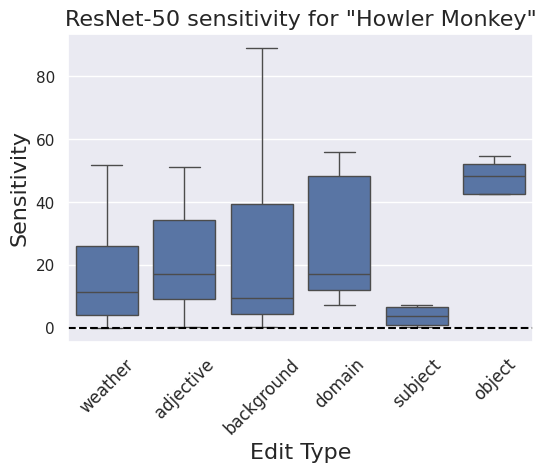

In [196]:
df_class = df_cluster[df_cluster['Label']=='howler monkey']
plot_sensitivity(df_class, 'ResNet-50', 'Howler Monkey', x="Edit Type", y="Sensitivity", sort_by=[])

#### Sensitivity by edit cluster

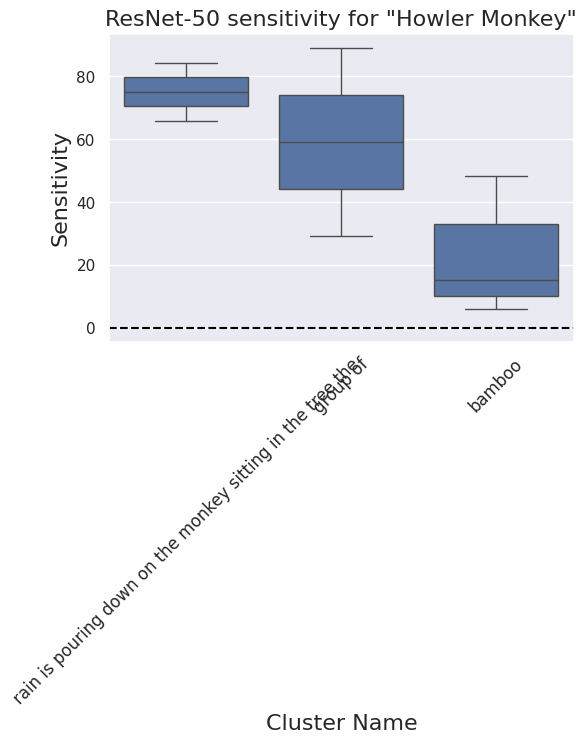

In [197]:
df_class_valid = df_class[df_class['Cluster'].isin(valid_clusters['howler monkey'])]
plot_sensitivity(df_class_valid, 'ResNet-50', 'Howler Monkey', x="Cluster Name", y="Sensitivity", sort_by=['Avg. sensitivity'])